# Model Iteration 
### SF-Crime Kaggle Challenge      2.23.16
##### Data Science 2016 - CYOA Project.
_______________________________________________________

##### Olin College
##### David Abrahams & Brenna Manning


#### Imports

In [26]:
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import scipy.stats as st
import random
from datetime import datetime
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from patsy import dmatrix, dmatrices
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import log_loss
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer, LabelEncoder
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator
from sklearn.cross_validation import StratifiedKFold
from sklearn.dummy import DummyClassifier

#### Load Data

In [27]:
cur_dir = os.path.dirname('__file__')

train = pd.read_csv(os.path.join(cur_dir, "data", "train.csv"))
test = pd.read_csv(os.path.join(cur_dir, "data", "test.csv"))
#mapdata = np.loadtxt(os.path.join(cur_dir, "data", "sf_map.txt"))

#### Define functions to be used later

In [28]:
def get_random_subset(df, n=None):
    if (n is None):
        return df
    sub = random.sample(xrange(len(df)), min(n, len(df)))
    return df.iloc[sub]

def preprocess(df, drop=True):
    res = df.copy()
    if (drop):
        res = res[res.X != res.X.max()]
    datetimes = res.Dates.apply(get_datetime)
    res['Hour'] = datetimes.apply(lambda dt: dt.hour)
    res['Month'] = datetimes.apply(lambda dt: dt.month)
    res['Hour_Minutes'] = datetimes.apply(lambda dt: dt.hour + dt.minute / 60.0)
    res['Minutes_Since_03'] = datetimes.apply(lambda dt: (dt-datetime(2003, 1, 1)).total_seconds() / 60)
    res['Minutes_Since_New_Year'] = datetimes.apply(lambda dt: (dt-datetime(dt.year, 1, 1)).total_seconds() / 60)
    res['Street_Corner'] = res['Address'].apply(lambda x: 1 if '/' in x else 0)
    res['Weekend'] = res.DayOfWeek.isin(['Saturday, Sunday'])
    return res

def get_datetime(s):
    dt = datetime.strptime(s, "%Y-%m-%d %H:%M:%S")
    return dt

dow = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

def isNight(hour):
    if hour in [0, 1, 2, 3, 4, 5, 6, 19, 20, 21, 22, 23]:
        return "Night"
    else:
        return "Day"

In [29]:
def train_models(models, x_train, y_train):
    for m in models:
        m.fit(x_train, y_train)
        
def get_x_matrix(df, formula):
    x_vals = dmatrix(formula, data=df, return_type='dataframe')
    return x_vals
        
def get_x_y_matrices(df, formula, target, filt=True):
    
    x_vals = dmatrix(formula, data=df, return_type='dataframe')
    y_vals = df[target]
    if (filt):
        return filter_infrequent(x_vals, y_vals)
    return x_vals, y_vals
    
def filter_infrequent(x, y, threshold=3):
    counts = y.value_counts()
    for cat, count in counts.iteritems():
        if count < 3:
            x = x[y != cat]
            y = y[y != cat]
            
    return x, y

#### Classifiers Used in this iteration

In [30]:
class ProbaRandomForestClassifier(RandomForestClassifier):
    def predict(self, X):
        return self.predict_proba(X)
        
class ProbaLogisticRegression(LogisticRegression):
    def predict(self, X):
        return self.predict_proba(X)

#### Get smaller subset of data to use when not final submission for speed.

In [33]:
#train_df = preprocess(get_random_subset(train, len(train), drop=False)
train_df = preprocess(train)

Features to consider selected using Patsy
Predictions made using RandomForestClassifier algorithm.


### Plot of Scores for each crime using Random Forest Classifier

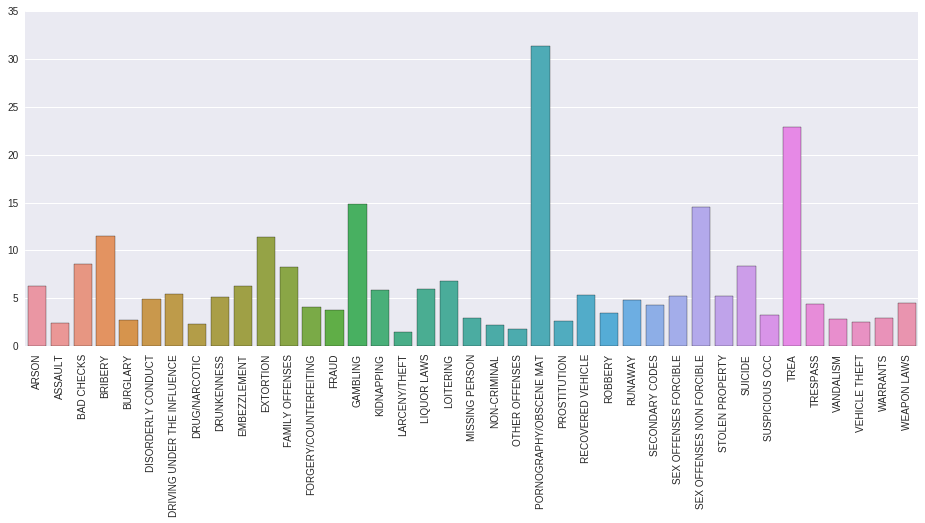

In [38]:
formula_ml = 'C(DayOfWeek) + C(PdDistrict) + Street_Corner + X+Y+Hour+Month'

x_vals, y_vals = get_x_y_matrices(train_df, formula_ml, 'Category')

lb = LabelBinarizer()
lb.fit(y_vals)
y_vals_matrix = lb.transform(y_vals)

clf_forest = ProbaRandomForestClassifier(min_samples_leaf=300)

predictions = cross_val_predict(clf_forest, x_vals, y_vals)
crimes = lb.classes_
scores = []

for i, crime in enumerate(crimes):
    indexor = (y_vals == crime).values
    scores.append(log_loss(y_vals_matrix[indexor], predictions[indexor]))
    
ax = sns.barplot(x=crimes, y=scores)
plt.sca(ax)
plt.xticks(rotation=90)
    
plt.gcf().set_size_inches(16, 6, forward=True)

### Normalize to crime frequency

LARCENY/THEFT                  174885
OTHER OFFENSES                 126165
NON-CRIMINAL                    92300
ASSAULT                         76872
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53772
VANDALISM                       44724
WARRANTS                        42206
BURGLARY                        36754
SUSPICIOUS OCC                  31412
MISSING PERSON                  25989
ROBBERY                         22999
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7325
STOLEN PROPERTY                  4539
SEX OFFENSES FORCIBLE            4387
DISORDERLY CONDUCT               4318
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

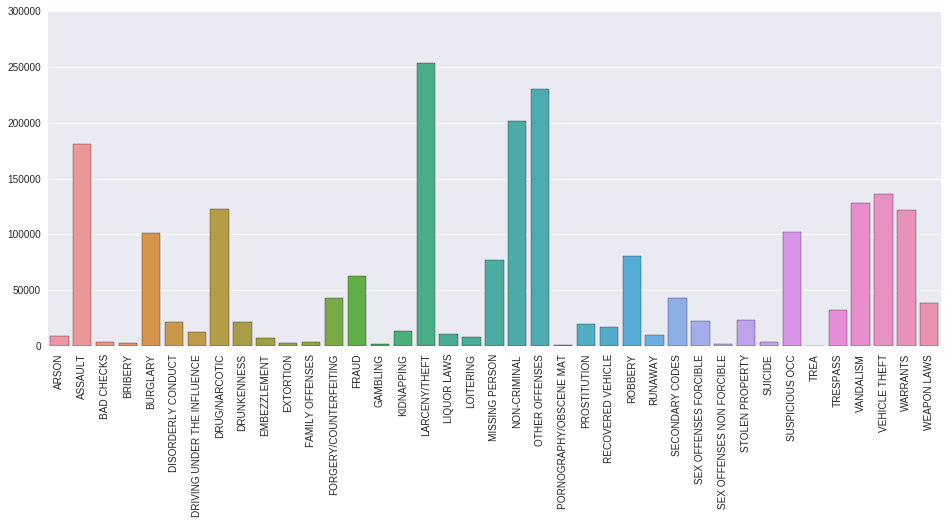

In [35]:
counts = y_vals.value_counts()
print counts
weighted_scores = []
for i, crime in enumerate(crimes):
    weighted_scores.append(scores[i] * counts[crime])
ax = sns.barplot(x=crimes, y=weighted_scores)
plt.sca(ax)
plt.xticks(rotation=90)
    
plt.gcf().set_size_inches(16, 6, forward=True)

### Use Random Forest Classifier algorithm with optimized parameters and write to csv to submit.

In [36]:
alg = RandomForestClassifier(min_samples_leaf=300)
formula_ml = 'C(DayOfWeek) + C(PdDistrict) + Street_Corner + X+Y+Hour+Month'

x_train, y_train = get_x_y_matrices(train_df, formula_ml, 'Category')
alg.fit(x_train, y_train)

predictions = alg.predict_proba(get_x_matrix(preprocess(test,drop=False), formula_ml))
predictions = pd.DataFrame(predictions, index=test.index, columns=alg.classes_)

predictions.to_csv("predictions.csv", index_label="Id")

# labels =['Id']
# for i in alg.classes_:
#     labels.append(i)
# with gzip.open('sfcrime.csv.gz', 'wb') as outf:
#     fo =csv.writer(outf, lineterminator = '\n' )
#     fo.writerow(labels)
    
#     for i, pred in enumerate(predictions):
#         fo.writerow([i] + list(pred))

# Resultant Kaggle Score: 2.45